# What

As discussed in #146 it seems that a searching problem is what this will turn into.

Using a vector dba nd rag could be the best way for people to search through all of the reports

## Modules

In [5]:
# from me
from engine.OpenAICaller import openAICaller

# third party

import lancedb
import pyarrow as pa

import yaml
import pandas as pd

from sentence_transformers import SentenceTransformer
import voyageai
from transformers import AutoTokenizer

from dotenv import load_dotenv

# built in
import os

load_dotenv()


True

# Gauging size

The initial idea would be to have all of the important text inside the vetor database. This means that the searching could happen with most of the report.

In [5]:
# load all import text

reports = [dir for dir in os.listdir('output') if os.path.isdir(os.path.join('output', dir))]

important_texts = []

for report in reports:

    important_text_path = os.path.join('output', report, f'{report}_important_text.yaml')
    
    if not os.path.exists(important_text_path):
        continue

    with open(important_text_path, 'r') as f:
        text = yaml.safe_load(f)['text']

    if text == None:
        continue

    important_texts.append({
        'report_id': report,
        'text': text
    })

important_texts_df = pd.DataFrame(important_texts)



In [24]:
important_texts_df['gpt-3.5_tokens'] = important_texts_df['text'].apply(lambda x: openAICaller.get_tokens([x])[0])

97.08% are under 13333.33 tokens. With a total sum of 746319 tokens.


,report_id,text,gpt-3.5_tokens,llama2_tokens
57,2014_006,<< Page 15 >>\n Final report AO -2014 -006 4....,15404,2
73,2012_201,<< Page 18 >>\n Report 12 -201 4. Analysis \n...,17996,2
86,2019_005,<< Page 25 >>\n 3 Analysis \nTātaritanga \nI...,14891,2
122,2011_204,<< Page 17 >>\n 4. Analysis \n4.1. Introducti...,27556,2


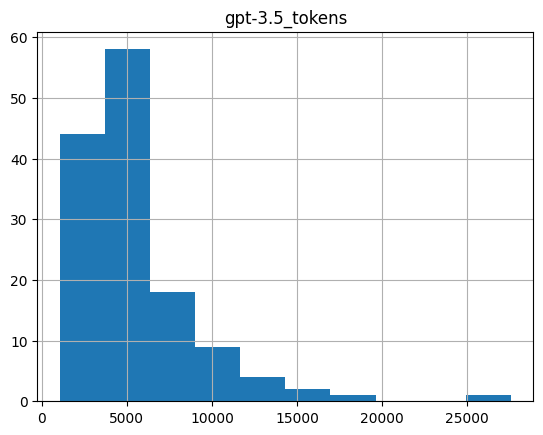

In [28]:
important_texts_df.hist(column='gpt-3.5_tokens')

# Check what token cutoff is reasonable

max_tokens = 16_000/1.2

print(f'{important_texts_df[important_texts_df["gpt-3.5_tokens"] < max_tokens].shape[0] / important_texts_df.shape[0] * 100:.2f}% are under {max_tokens:.2f} tokens. With a total sum of {important_texts_df["gpt-3.5_tokens"].sum()} tokens.')

important_texts_df[important_texts_df['gpt-3.5_tokens'] > max_tokens]



# Embedding



## Using sentence transformers

I have started looking at this but using sentence transformers wont work due to the size of documents I am working with.

I may come back to this and see if I can use a smaller embeddings model to do the embeddings on the split document.

In [3]:
# Using a big model like this is not doable on my computer

model = SentenceTransformer('sentence-transformers/gtr-t5-xxl')

## This wont work here as I need a computer with much more ram and gpu capabilities.

: 

In [ ]:
important_texts_df['embeddings'] = important_texts_df['text'].apply(lambda x: model.encode(x))

## Using voyageai

Voyage AI seems to have the largest embedding model that can take the input up to 16,000 tokens. This is much better than offered by openai embeddings models. With this extra size it allows me to vector search the whole document and not have to split it up into chunks. Alternatively I could start experimenting with Anthropic and their model offerings.

However I have an idea of splitting the documents up into chunks and using it to provide more accurate and usual information to the LLM prompt.

In [32]:
vo = voyageai.Client()

In [41]:
## Generating the embeddings
important_texts_df['voyage_embeddings'] = important_texts_df['text'].apply(lambda x: vo.embed(x, model="voyage-large-2", input_type="document").embeddings[0])

In [ ]:
important_texts[['report_id', 'voyage_embeddings']].rename(
    columns={'voyage_embeddings': 'vector'}
    ).to_pickle('embeddings.pkl')

# Vector database

I will now test out importing the embeddings into a vector database.



## Getting dataset ready

There are three things that we need for this data set
    - ids
    - payload
    - embeddings

The ids will be converted from the report_ids

payload will include all the data we are interested in:

Embedding have been calculated above using voyageAI.

### Getting embeddings and ids

In [36]:
embeddings = pd.read_pickle('embeddings.pkl')

embeddings['id'] = embeddings['report_id'].apply(lambda x: int(x.replace('_','')))

embeddings

,report_id,embedding,id
0,2019_106,"[-0.015029005706310272, -0.008748018182814121,...",2019106
1,2013_107,"[-0.005734662059694529, 0.0019134382018819451,...",2013107
2,2020_102,"[-0.00571523467078805, -0.0010110529838129878,...",2020102
3,2011_003,"[-0.027587836608290672, -0.012209959328174591,...",2011003
4,2012_105,"[-0.01278785988688469, -0.0002950807102024555,...",2012105
...,...,...,...
132,2017_101,"[-0.004187464248389006, -0.002563649322837591,...",2017101
133,2011_006,"[-0.024409988895058632, -0.008192344568669796,...",2011006
134,2017_003,"[-0.003574189031496644, 0.004126443527638912, ...",2017003
135,2017_104,"[-0.010454787872731686, 0.0033052992075681686,...",2017104


### Getting payload data

I will do this by using the search function from the viewer to turn the whole output folder into a dataframe.

Then I can join it in with the embeddings.

In [9]:
# I am just going to load it in from using the webapp and export button.

search_results = pd.read_csv('search_results.csv')

payload_df = search_results[search_results.columns.drop(['NoMatches', 'linksVisual', 'ErrorMessage'])]

payload_df.rename(columns={'ReportID': 'report_id'}, inplace=True)

payload_df

/tmp/ipykernel_11497/1703577779.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  payload_df.rename(columns={'ReportID': 'report_id'}, inplace=True)


,report_id,ThemeSummary,CompleteThemeSummary,SafetyIssues,CompleteSafetyIssues,Recommendations,CompleteRecommendations,Completelinks,Fatigue Management,CompleteFatigue ManagementReasoning,...,Maintenance and Inspection Regimes,CompleteMaintenance and Inspection RegimesReasoning,Use of Automation,CompleteUse of AutomationReasoning,Weather Conditions and Decision Making,CompleteWeather Conditions and Decision MakingReasoning,Communication Breakdown,CompleteCommunication BreakdownReasoning,Other,PDF
0,2018_206,Bridge Resource Management<br><br>Pilot Traini...,<h4>Bridge Resource Management</h4>Bridge Reso...,2,[{'safety_issue': 'The level of bridge resourc...,1,"['On 27 September 2021, the Commission made a ...",report_id recommendation_id ... quality ...,0.0,There is no mention in the report of fatigue m...,...,0.000,The report does not indicate that maintenance ...,0.000,The use of automation is not mentioned as a co...,5.0,The report indicates that the wind was from th...,0.000,The report does not indicate that a communicat...,0.0,"<a href=""https://www.taic.org.nz/inquiry/mo-20..."
1,2015_103,Role Overload and Conflicting Responsibilities...,<h4>Role Overload and Conflicting Responsibili...,3,[{'safety_issue': 'the KiwiRail system allowed...,1,['The Commission recommends to the Chief Execu...,report_id recommendation_id ... quality ...,0.0,There is no mention of fatigue or overwork con...,...,0.000,The document does not indicate that maintenanc...,0.000,There is no mention of automation or its impac...,0.0,Weather conditions are not mentioned as a cont...,12.500,While the communication between the rail prote...,0.0,"<a href=""https://www.taic.org.nz/inquiry/ro-20..."
2,2016_205,Inadequate Fall-Protection System<br><br>Lack ...,<h4>Inadequate Fall-Protection System</h4>The ...,2,"[{'safety_issue': ""The operator's risk assessm...",1,"['On 27 September 2017, the Commission recomme...",report_id recommendation_id ... quality ...,0.0,The document does not provide information sugg...,...,3.333,Although not directly cited as a cause of the ...,0.000,The document does not provide information sugg...,0.0,The document does not provide information sugg...,0.000,The document does not provide information sugg...,0.0,"<a href=""https://www.taic.org.nz/inquiry/mo-20..."
3,2019_101,Communication<br><br>Situational Awareness<br>...,<h4>Communication</h4>Communication is a criti...,4,[{'safety_issue': 'The RPO allowed a signals t...,0,[],NaN,0.0,There is no indication in the document that fa...,...,0.000,There is no evidence in the document that main...,0.000,The document does not mention the use of autom...,0.0,Weather conditions are not mentioned as a fact...,3.333,Communication breakdown between the RPO and th...,0.0,"<a href=""https://www.taic.org.nz/inquiry/ro-20..."
4,2016_101,Congested Track Layout<br><br>Ineffective Non-...,<h4>Congested Track Layout</h4>The congested t...,3,[{'safety_issue': 'There is a heightened risk ...,2,['the Commission recommended that the Chief Ex...,report_id recommendation_id ... quality ...,5.0,"The driver's mistake is considered a lapse, po...",...,0.000,There is no evidence in the document suggestin...,3.333,The Wellington Signalbox controlled area is ba...,5.0,"The arrows on the signals are ""not illuminated...",5.000,There had been no radio communication between ...,0.0,"<a href=""https://www.taic.org.nz/inquiry/ro-20..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,2013_203,Propeller and Shaft Maintenance<br><br>Adheren...,<h4>Propeller and Shaft Maintenance</h4>Propel...,6,[{'safety_issue': 'The quality of the fit achi...,2,['15.2.8.\tThe Commission recommends that Stan...,report_id recommendation_id ... quality ...,0.0,There is no mention of fatigue management cont...,...,0.000,The document does not indicate that inadequate...,0.000,The use of automation is not discussed as a co...,0.0,Weather conditions and decision making are not...,0.000,Communication

### Merging payload with embeddings

In [39]:
merged_df = pd.merge(embeddings, payload_df, on='report_id', how='left')

merged_df.rename(columns={'embedding': 'vector'}, inplace=True)

merged_df

,report_id,vector,id,ThemeSummary,CompleteThemeSummary,SafetyIssues,CompleteSafetyIssues,Recommendations,CompleteRecommendations,Completelinks,...,Maintenance and Inspection Regimes,CompleteMaintenance and Inspection RegimesReasoning,Use of Automation,CompleteUse of AutomationReasoning,Weather Conditions and Decision Making,CompleteWeather Conditions and Decision MakingReasoning,Communication Breakdown,CompleteCommunication BreakdownReasoning,Other,PDF
0,2019_106,"[-0.015029005706310272, -0.008748018182814121,...",2019106,Communication Breakdown<br><br>Inadequate Situ...,<h4>Communication Breakdown</h4>Communication ...,1.0,[{'safety_issue': 'No procedures were in place...,0.0,[],NaN,...,0.000,There is no indication in the document that ma...,0.000,"Automation was not a factor in the incident, a...",0.0,Weather conditions were not mentioned as a fac...,5.000,The lack of communication between the train co...,0.000,"<a href=""https://www.taic.org.nz/inquiry/ro-20..."
1,2013_107,"[-0.005734662059694529, 0.0019134382018819451,...",2013107,Wheel-bearing Failures<br><br>Inadequate Monit...,<h4>Wheel-bearing Failures</h4>Wheel-bearing f...,4.0,[{'safety_issue': 'The high incidence of brake...,1.0,['The Commission recommends that the chief exe...,report_id recommendation_id ... quality ...,...,40.000,The document highlights issues with the mainte...,30.000,"The document discusses the RailBAM system, whi...",0.0,Weather conditions and decision making are not...,0.000,There is no evidence in the document to sugges...,0.000,"<a href=""https://www.taic.org.nz/inquiry/ro-20..."
2,2020_102,"[-0.00571523467078805, -0.0010110529838129878,...",2020102,Compliance with Track Warrant Conditions<br><b...,<h4>Compliance with Track Warrant Conditions</...,2.0,[{'safety_issue': 'The track warrant control m...,0.0,[],NaN,...,0.000,There is no mention of equipment or infrastruc...,0.000,The document does not indicate that automation...,0.0,Weather conditions are not mentioned as a cont...,1.667,There was a communication breakdown between th...,0.000,"<a href=""https://www.taic.org.nz/inquiry/ro-20..."
3,2011_003,"[-0.027587836608290672, -0.012209959328174591,...",2011003,Main rotor blade divergence and loss of contro...,<h4>Main rotor blade divergence and loss of co...,4.0,"[{'safety_issue': ""The New Zealand regulatory ...",4.0,['On 26 February 2014 the Commission recommend...,report_id recommendation_id ... quality ...,...,1.667,The document states that an inspection of the ...,0.000,The document does not discuss the use of autom...,25.0,The helicopter was operating in conditions of ...,0.000,The document does not indicate that communicat...,0.000,"<a href=""https://www.taic.org.nz/inquiry/ao-20..."
4,2012_105,"[-0.01278785988688469, -0.0002950807102024555,...",2012105,Human Error in Manual Route Setting<br><br>Mis...,<h4>Human Error in Manual Route Setting</h4>Hu...,4.0,[{'safety_issue': 'The safety issue arising fr...,0.0,[],NaN,...,0.000,There were no issues associated with the track...,3.333,The lack of automatic route setting due to ong...,0.0,The document does not mention weather conditio...,0.000,Communication breakdown was a significant fact...,0.000,"<a href=""https://www.taic.org.nz/inquiry/ro-20..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132,2017_101,"[-0.004187464248389006, -0.002563649322837591,...",2017101,Human Factors - Fatigue and Alertness<br><br>M...,<h4>Human Factors - Fatigue and Alertness</h4>...,3.0,"[{'safety_issue': ""the KiwiRail medical assess...",2.0,['the Commission recommended that the Chief Ex...,report_id recommendation_id ... quality ...,...,0.000,The document does not indicate that maintenanc...,50.000,"The eProtect system, an automated safety defen...",0.0,Weather conditions and decision-making were no...,0.000,There is no evidence in the document suggestin...,0.000,"<a href=""https://www.taic.org.nz/inquiry/ro-20..."
133,2011_006,"[-0.024409988895058632, -0.008192344

## Creating vector database

In [ ]:
# Setting up lanceDB

!poetry add lancedb

In [3]:
# Create db

uri = 'taic-report-lancedb-test'

db = lancedb.connect(uri)

In [40]:
# Create new table
db.drop_table('taic-reports')
tbl = db.create_table(
    'taic-reports',
    data = merged_df
) 


In [41]:
tbl.head()

pyarrow.Table
report_id: string
vector: fixed_size_list<item: float>[1536]
  child 0, item: float
id: int64
ThemeSummary: string
CompleteThemeSummary: string
SafetyIssues: double
CompleteSafetyIssues: string
Recommendations: double
CompleteRecommendations: string
Completelinks: string
Fatigue Management: double
CompleteFatigue ManagementReasoning: string
Human Error and Assumptions: double
CompleteHuman Error and AssumptionsReasoning: string
Training and Competency: double
CompleteTraining and CompetencyReasoning: string
Training and Familiarity with Equipment: double
CompleteTraining and Familiarity with EquipmentReasoning: string
Crew Resource Management: double
CompleteCrew Resource ManagementReasoning: string
Adherence to Safety Procedures: double
CompleteAdherence to Safety ProceduresReasoning: string
Organizational Safety Culture: double
CompleteOrganizational Safety CultureReasoning: string
Risk Management and Analysis: double
CompleteRisk Management and AnalysisReasoning: strin

In [47]:
vo = voyageai.Client()

def search_vectorDB(text, tbl, results = 10):
    search_text = text

    search_text_embeded = vo.embed(search_text, model="voyage-large-2", input_type="document").embeddings[0]

    return tbl.search(search_text_embeded).to_pandas()












**Example below**

In [51]:
search_vectorDB('I want to know about accidents that had drug and alcohol involved', tbl, results = 10)

,report_id,vector,id,ThemeSummary,CompleteThemeSummary,SafetyIssues,CompleteSafetyIssues,Recommendations,CompleteRecommendations,Completelinks,...,CompleteMaintenance and Inspection RegimesReasoning,Use of Automation,CompleteUse of AutomationReasoning,Weather Conditions and Decision Making,CompleteWeather Conditions and Decision MakingReasoning,Communication Breakdown,CompleteCommunication BreakdownReasoning,Other,PDF,_distance
0,2019_202,"[-0.00546641, 0.027256737, 0.035306882, 0.0296...",2019202,None,None,NaN,None,NaN,None,None,...,None,NaN,None,NaN,None,NaN,None,NaN,None,0.410504
1,2020_103,"[-0.017417477, 0.0072473385, 0.043419864, 0.00...",2020103,Habituation to Routine<br><br>Driver Expectati...,<h4>Habituation to Routine</h4>Habituation to ...,2.0,[{'safety_issue': 'There was no evidence that ...,1.0,['The Commission recommended that Waka Kotahi ...,report_id recommendation_id ... quality ...,...,The level crossing warning devices were found ...,0.0,There is no mention of automation or its misus...,0.0,The Commission found no evidence that factors ...,0.000,There is no mention of communication breakdown...,0.0,"<a href=""https://www.taic.org.nz/inquiry/ro-20...",0.448771
2,2018_205,"[-0.00028828153, 0.0012286317, 0.040673904, 0....",2018205,Lack of Specific Risk Assessments and Safe Ope...,<h4>Lack of Specific Risk Assessments and Safe...,2.0,[{'safety_issue': 'the risks associated with o...,1.0,['On 25 March 2020 the Commission recommended ...,report_id recommendation_id ... quality ...,...,Maintenance and inspection regimes are not men...,2.5,Use of automation is not directly implicated i...,0.0,Weather conditions and decision making are not...,0.000,Communication breakdown is not mentioned as a ...,10.0,"<a href=""https://www.taic.org.nz/inquiry/mo-20...",0.453545
3,2020_001,"[-0.007201426, 0.028076742, 0.04301568, 0.0197...",2020001,Pilot Incapacitation<br><br>Mechanical Failure...,<h4>Pilot Incapacitation</h4>Pilot incapacitat...,1.0,[{'safety_issue': 'The lack of evidence of any...,0.0,[],None,...,There was no evidence to indicate a failure of...,0.0,The document does not discuss the use of autom...,0.0,Weather conditions were not identified as a co...,0.000,There is no mention of communication breakdown...,100.0,"<a href=""https://www.taic.org.nz/inquiry/ao-20...",0.454391
4,2010_202,"[-0.00069887243, 0.023439402, 0.040558733, 0.0...",2010202,Inadequate Monitoring of Vessel Progress<br><b...,<h4>Inadequate Monitoring of Vessel Progress</...,5.0,[{'safety_issue': 'A working bridge watch navi...,3.0,['The Commission recommends the Director of Ma...,report_id recommendation_id ... quality ...,...,The grounding was not a result of any technica...,0.0,There is no specific mention of the use or mis...,0.0,There is no specific mention of weather condit...,1.667,There is no specific mention of communication ...,0.0,"<a href=""https://www.taic.org.nz/inquiry/mo-20...",0.461005
5,2014_102,"[-0.018792985, -0.0008027107, 0.04603354, 0.02...",2014102,Human Performance Limitations<br><br>Signallin...,<h4>Human Performance Limitations</h4>Human pe...,2.0,[{'safety_issue': 'There was no defence in the...,1.0,['The Commission recommends that the Chief Exe...,report_id recommendation_id ... quality ...,...,The train's braking system was compliant with ...,10.0,The report mentions that the train protection ...,0.0,Weather conditions are not mentioned as a fact...,0.000,The lack of communication from the train contr...,0.0,"<a href=""https://www.taic.org.nz/inquiry/ro-20...",0.462269
6,2012_202,"[-0.0022791224, 0.010408244, 0.053372987, 0.05...",2012202,Passenger Overloading<br><br>Navigation in Haz...,<h4>Passenger Overloading</h4>Passenger overlo...,1.0,[{'safety_issue': 'There were 24 passengers on...,0.0,[],None,...,There is no mention of maintenance or inspecti...,0.0,The document does not indicate that automation...,0.0,Weather conditions were suitable for the trip ...,0.000,While there was a failure to communicate the c...,0.

# Rag

To setup a rag I need to have a returned documents that are smaller than the context limit of 128k.

Given each report is about 10 tokens this only allows for about 10 reports in the context. It might be better to have smaller chunks that then link to the original one.